In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib inline

data = pd.read_csv('Cleaned data.csv')




Calculate several fields to be used in calculations...
	The "Total" scores for each type of survery respondent
	The number of Extracurriculars offered at a school by finding the number of commas in the EC field and adding 1.  
	Which schools offer an SAT prep course by searching for SAT
	The schools that use the SHSAT for admissions by searching the addt_info1 field, since that's where references
		to the SHSAT are made. The data is missing for 3 schools though, so add them in manually
	The schools that have ell_percents higher than 70, giving them a 'High Ell per' value of 1
	The % of students in a school that take the SAT
	The correlation values between each numberic field


In [3]:
data['Student Total'] = (data["saf_s_11"] + data["com_s_11"] + data["eng_s_11"] + data["aca_s_11"])/4
data['Parent Total'] = (data["saf_p_11"] + data["com_p_11"] + data["eng_p_11"] + data["aca_p_11"])/4
data['Teacher Total'] = (data["saf_t_11"] + data["com_t_11"] + data["eng_t_11"] + data["aca_t_11"])/4


data['Number of ECs'] = 1+data['extracurricular_activities'].apply(lambda x: str.count(x, ','))
data['SAT Course'] = data['extracurricular_activities'].apply(lambda x: 0 if str.find(x,'SAT') < 0 else 1)

data['SHSAT School'] = data['addtl_info1'].apply(lambda x: 0 if str.find(str(x),'SHSAT') < 0 else 1)
missedSHSAT = ['BRONX HIGH SCHOOL OF SCIENCE', 'BROOKLYN TECHNICAL HIGH SCHOOL', 'BROOKLYN LATIN SCHOOL, THE']
data['SHSAT School'][data['SCHOOL NAME'].isin(missedSHSAT)] = 1

data['High Ell Per'] = data['ell_percent'].apply(lambda x: 1 if x > 70 else 0)

data['SAT percent'] = data['Num of SAT Test Takers']/data['total_enrollment']

correlations = data.corr()

C:\Users\Ryan\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Create a bar chart of the survey responses, grouped and colored by respondent type

C:\Users\Ryan\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


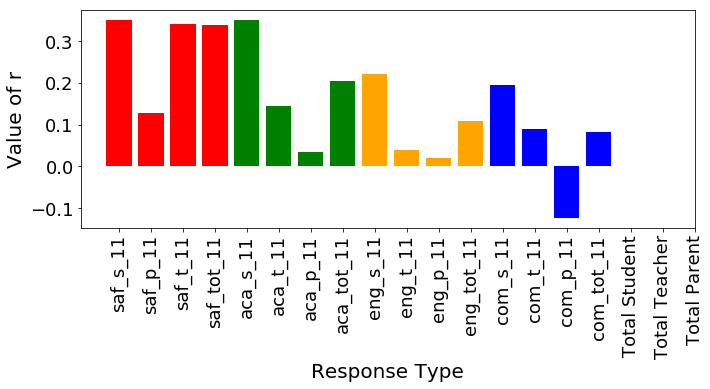

In [4]:
survey_fields = ["saf_s_11", "saf_p_11", "saf_t_11", "saf_tot_11", "aca_s_11", "aca_t_11",
    "aca_p_11", "aca_tot_11", "eng_s_11",  "eng_t_11", "eng_p_11", "eng_tot_11", "com_s_11", "com_t_11","com_p_11",
      "com_tot_11", 'Total Student', 'Total Teacher', 'Total Parent']
fig, ax = plt.subplots(figsize = (11,4))
colors = ['red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'orange', 'orange', 'orange', 'orange', 'blue', 'blue',
          'blue', 'blue', 'brown', 'brown','brown']
barLocs = np.arange(survey_fields.__len__())
ax.bar(barLocs, correlations["SAT_score"][survey_fields], color=colors)
plt.xlabel('Response Type', fontsize=20)
plt.ylabel('Value of r', fontsize=20)
ax.set_xticklabels(survey_fields, rotation=90)
ax.set_xticks(barLocs)
ax.tick_params(labelsize=18)


Create a bar graph correlation values for the race statistics

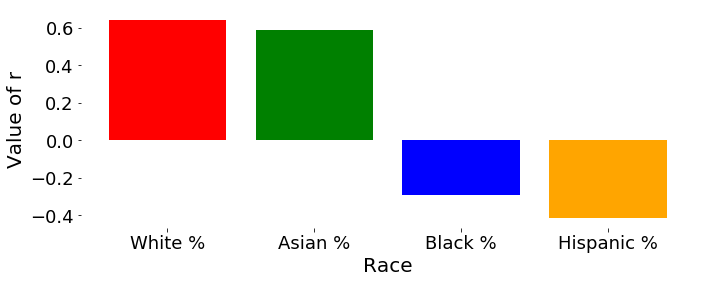

In [5]:

fig, ax = plt.subplots(figsize = (11,4))
colors = ['red', 'green', 'blue', 'orange']
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
barLocs = np.arange(race_fields.__len__())
ax.bar(barLocs, correlations["SAT_score"][race_fields], color=colors)
plt.xlabel('Race', fontsize=20)
plt.ylabel('Value of r', fontsize=20)
ax.set_xticklabels(["White %", "Asian %", "Black %", "Hispanic %"])
ax.set_xticks(barLocs)
ax.tick_params(labelsize=18)
for key,spine in ax.spines.items():
    spine.set_visible(False)


Predictive modelling, run n times, using the variables listed
Accuracy is used to store the averages of the absolute value of the residuals for each run
Split the data into a learning set (70% of the data) and a testing set (30% of the data)
Create a model based on the learning set, then use the model to make predictions on the test set
The "residuals" data frame contains all of the testing sets used throughout the n trials, including the predicted values
and associated residuals

In [7]:
variables = ['frl_percent', 'SHSAT School', 'High Ell Per', 'asian_per', 'black_per', 'hispanic_per', 'ell_percent', 'Advanced Regents - % of cohort']
n= 100
accuracy = []
residuals = pd.DataFrame()
for i in range(n):
    data['Learning Set'] = np.random.random(data.__len__())
    learningSet = data[data['Learning Set'] < .7]
    testSet = data[data['Learning Set'] >=.7]
    x = learningSet[variables]
    y = learningSet['SAT_score']
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()

    testX  = testSet[variables]
    testX = sm.add_constant(testX)
    testSet['predictions'] = model.predict(testX)
    testSet['residuals'] = testSet['SAT_score'] - testSet['predictions']
    accuracy.append(testSet['residuals'].map(abs).mean())
    residuals = residuals.append(testSet)


print('Average Error Across ' + str(n) + ' Trials: ' + str(float(sum(accuracy))/len(accuracy)))
print(residuals['residuals'].describe())
print(residuals['residuals'].abs().describe())


residuals.to_csv('Model Residuals.csv', index=False)


C:\Users\Ryan\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


C:\Users\Ryan\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Average Error Across 100 Trials: 53.42994594656599
count    10104.000000
mean         1.288946
std         74.215776
min       -302.738613
25%        -45.183184
50%         -5.021881
75%         39.325306
max        506.078254
Name: residuals, dtype: float64
count    10104.000000
mean        53.401265
std         51.552552
min          0.006180
25%         19.172613
50%         42.934498
75%         69.998993
max        506.078254
Name: residuals, dtype: float64
